In [1]:
# import libraries
import pandas as pd

import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('all')

In [6]:
# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text

    tokens = word_tokenize(text.lower())


    # Remove stop words

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]


    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]


    # Join the tokens back into a string

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# Sentiment Analysis

In [ ]:
!pip install transformers

## Prepare data

In [129]:
file = 'The Little Prince.txt'
docs = []
last = 0
with open(file, "r", encoding="utf-8") as file1:
    FileContent = file1.read()
    FileContent = FileContent.lower() # lowercase
    for i in range(len(FileContent)):
      if FileContent[i] in ['.', '?', '!'] and FileContent[i+1] == ' ':
        docs.append(preprocess_text(FileContent[last:i+1])) 
        last = i+1

In [10]:
docs[0],docs[1],docs[2],docs[3],docs[4]

('little prince chapter 1 six year old spotted magnificent picture book ancient forest .',
 'picture showed boa constrictor act swallowing wild beast .',
 'looked like : said book : ‘ boa constrictor swallow prey whole , without chewing .',
 ', unable move sleep next six month – needed digestion. ’ thought deeply experience forest .',
 ', care coloured pencil , succeeded making first drawing .')

In [130]:
df_docs = pd.DataFrame(docs, columns=['text'])
df_docs.head()

,text
0,little prince chapter 1 six year old spotted m...
1,picture showed boa constrictor act swallowing ...
2,looked like : said book : ‘ boa constrictor sw...
3,", unable move sleep next six month – needed di..."
4,", care coloured pencil , succeeded making firs..."


## NLTK sentiment analyzer

In [47]:
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
      sentiment = 1
    elif scores['compound'] <= -0.05:
      sentiment = -1
    else:
      sentiment = 0

    return sentiment

def get_sentiment_new(text):

    scores = analyzer.polarity_scores(text)
    if scores['pos'] == scores['neg']:
      senti = 0
    if scores['pos'] >= max(scores['neg'], scores['neu']):
      senti = 1
    elif scores['neg'] >= max(scores['pos'], scores['neu']):
      senti = -1
    elif scores['neu'] > max(scores['pos'], scores['neg']):
      senti = 0


    return senti


def get_sentiment_score(text):

    scores = analyzer.polarity_scores(text)

    return scores

In [131]:
# apply get_sentiment function

df_docs['nltk'] = df_docs['text'].apply(get_sentiment) # 0,-1,1
nltk_senti = df_docs['text'].apply(get_sentiment_score)

In [132]:
df_docs['nltk_max'] = df_docs['text'].apply(get_sentiment_new)

In [133]:
list_nltk_score = []
for i in range(len(nltk_senti)):
  list_nltk_score.append(nltk_senti[i]['compound'])
# list_nltk_score

In [57]:
t = 603
nltk_senti[t], list_nltk_score[t], df_docs['nltk'][t]

({'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, 0.0, 0)

## transformers-pipline



In [21]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [29]:
# sample
result = nlp(["I hate you", 'I love you'])
print(result)

[{'label': 'NEGATIVE', 'score': 0.9991129040718079}, {'label': 'POSITIVE', 'score': 0.9998656511306763}]


In [134]:
# apply get_sentiment function
senti_pip_lab = []
senti_pip_score = []
for sen in range(len(df_docs['text'])):
  resulit = nlp(df_docs['text'][sen])
  senti_pip_score.append(nlp(df_docs['text'][sen])[0]['score'])
  if nlp(df_docs['text'][sen])[0]['label'] == 'POSITIVE':
    senti_pip_lab.append(1)
  elif nlp(df_docs['text'][sen])[0]['label'] == 'NEGATIVE':
    senti_pip_lab.append(0)

In [135]:
df_docs['senti_pip_lab'] = senti_pip_lab
df_docs['senti_pip_score'] = senti_pip_score

In [136]:
#Get top most negative 50 sentences 
df = df_docs.loc[df_docs['senti_pip_lab'] == 1].sort_values(by='senti_pip_score', ascending=True )[:50]
df.head(10)

,text,nltk,nltk_max,senti_pip_lab,senti_pip_score
586,"eye see important. ’ ‘ eye see important , ’ l...",1,0,1,0.517398
740,never told story anyone .,0,0,1,0.522650
363,"‘ star ? ’ ‘ oversee , ’ replied businessman .",0,0,1,0.545930
235,volcanic eruption like fire chimney .,0,0,1,0.555050
636,"song pulley still ear , could see trembling re...",-1,0,1,0.557528
486,‘ think six seven .,0,0,1,0.560618
617,"’ think anyone ever known find , even looked .",0,0,1,0.562081
350,little golden object cause people daydream .,0,0,1,0.565026
390,would put lamp morning light evening .,0,0,1,0.565214
593,child press face windows. ’ ‘ child know looki...,0,0,1,0.566438


In [137]:
import numpy as np
pip_senti = []
new_list_senti_score = [] # pip
nltk_senti_lab = []
# nltk_score = []

for i in range(len(senti_pip_lab)):
  if senti_pip_lab[i] == 0:
    new_list_senti_score.append(-1*senti_pip_score[i])
    pip_senti.append(-1)
  else:
    new_list_senti_score.append(senti_pip_score[i])
    pip_senti.append(1)

  nltk_senti_lab.append(df_docs['nltk'][i])
  # nltk_score.append(list_nltk_score[i])



In [138]:
nltk_max_lab = list(df_docs['nltk_max'])

In [139]:
sum_senti_pip = np.cumsum(pip_senti)
sum_senti_pip_score = np.cumsum(new_list_senti_score)

sum_senti_nltk = np.cumsum(nltk_senti_lab)
sum_senti_nltk_score = np.cumsum(list_nltk_score)

In [140]:
sum_nltk_max_lab = np.cumsum(nltk_max_lab)

In [161]:
len(sum_senti_nltk)

761

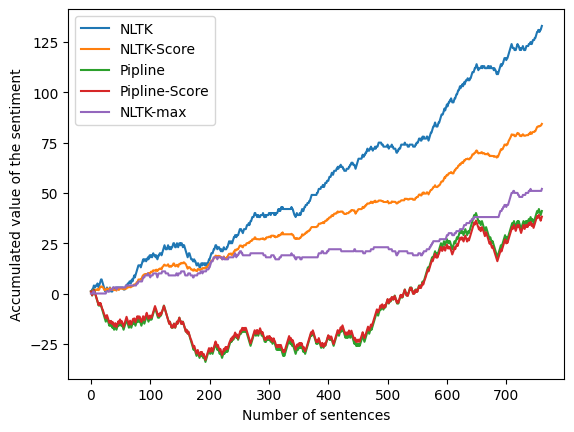

In [141]:
import matplotlib
import matplotlib.pyplot as plt
plt.plot(sum_senti_nltk, label='NLTK')
plt.plot(sum_senti_nltk_score, label='NLTK-Score')
plt.plot(sum_senti_pip, label='Pipline')
plt.plot(sum_senti_pip_score, label='Pipline-Score') #pip
plt.plot(sum_nltk_max_lab, label='NLTK-max')
plt.xlabel('Number of sentences')
plt.ylabel('Accumulated value of the sentiment')
plt.legend()

## Sentiment Analysis according to the chapter

+ characters in each chapter

In [187]:
file = 'The Little Prince.txt'
docs = []
last = 0
with open(file, "r", encoding="utf-8") as file1:
    FileContent = file1.read()
    FileContent = FileContent.lower() # lowercase
    for i in range(len(FileContent)):
      if FileContent[i] == 'c' and FileContent[i+1] == 'h' and FileContent[i+2] == 'a' and FileContent[i+3] == 'p'\
      and FileContent[i+4] == 't':
        docs.append(preprocess_text(FileContent[last-1:i])) 
        last = i+1

In [196]:
senti_lab_record = {}
senti_score_record = {}
for i in range(1,len(docs)):
  cha_now = docs[i]
  
  cha_list = []
  last = 0
  for sen in range(len(cha_now)-1):
    if cha_now[sen] == ',' and cha_now[sen+1] == ' ':
      cha_list.append(preprocess_text(cha_now[last : sen+1])) 
      last = sen + 1

  senti_lab = []
  senti_score = []

  result = nlp(cha_list)
  for item in result:
    if item['label'] == 'NEGATIVE':
      senti_lab.append(-1)
      senti_score.append(-1*item['score'])
    else:
      senti_lab.append(1)
      senti_score.append(item['score'])

  senti_lab_record[i] = senti_lab
  senti_score_record[i] = senti_score

In [198]:
cum_senti_score_record = {}
cum_senti_lab_record = {}
for i in senti_score_record.keys():
  cum_senti_score_record[i] = np.cumsum(senti_score_record[i])
  cum_senti_lab_record[i] = np.cumsum(senti_lab_record[i])


In [ ]:
!pip install matplotlib.colors

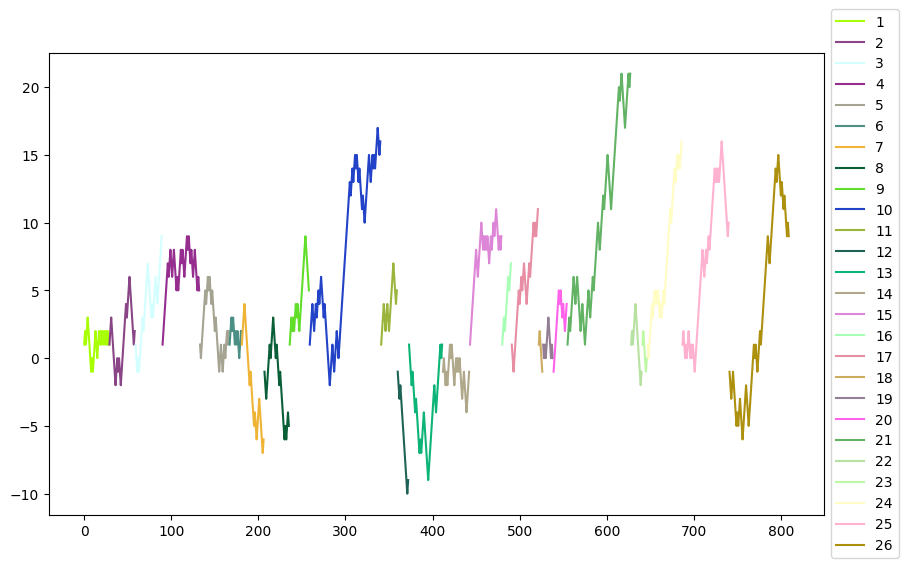

In [207]:
from random import choice
import matplotlib.colors as mcolors

colours = mcolors._colors_full_map # This is a dictionary of all named colours
# Turn the dictionary into a list
color_lst = list(colours.values()) 

plt.figure(figsize=(10,6))
count = 0 
for i in range(1, len(cum_senti_lab_record)+1):
  my_list = [i for i in range(count, count + len(cum_senti_lab_record[i]))]
  plt.plot(my_list, list(cum_senti_lab_record[i]), label=str(i), color=color_lst[2*i+1])
  count += len(cum_senti_lab_record[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))